At this point we have traced the entire gpytorch library. Everything is on the table. I plan to surgically modify the `gpytroch.MultivariateNormal` class to take in an optional preconditioner to overwrite the `linear_operator.inv_log_quad_det` behavior. Lets get started we will start by working with a 2/9 split of bike which should be cheap 

In general we have `ExactGP` - > `Gaussian Likliehood` - > `MultivariateNormal`

In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import time 
import gpytorch
from gpytorch.functions import pivoted_cholesky

from gpytorch.kernels import ScaleKernel, MaternKernel, RBFKernel
from gpytorch.priors import GammaPrior
from gpytorch.likelihoods import GaussianLikelihood
import torch
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
# Set device and global dtype
device = "cuda:0"
global_dtype = torch.float32

# Ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Add project source path
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '../code'))
if src_path not in sys.path:
    sys.path.append(src_path)
from LBFGS import LBFGS

# Import custom modules
from gps import CholeskyGaussianProcess, IterativeGaussianProcess
from util import train, eval, plot_gpr_results, fetch_uci_dataset, memory_dump
from plotting import plot_gp_simple, plot_gp_sample, plot_gp_simple_regions
device = "cuda:0"
# Enable autoreloading of modules
%load_ext autoreload
%autoreload 2
train_x, train_y, test_x, test_y = fetch_uci_dataset('bike',r"C:\Users\fredw\chris\Research\softki\data\uci_datasets\uci_datasets\elevators\data.csv",train_frac=9/10,val_frac=0)
train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print(train_x.shape)

[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode
SIZE (16599, 19)
Dataset loaded
torch.Size([14939, 17])


In  order to develop this the first step is to expose the precondioner behavior and add tracking flags for runtime splits. To do so we need to get into `linear_operator.inv_log_quad_det` which could be pretty hard based on past experience. To do so I think a nice first step is to overload `MultivariateNormal`. Since the class is huge we will start with a seperate file. 

In [2]:
from MNormal import CustomMultivariateNormal

The only function we really care about is `log_prob` which contains the log det call for mll computation with `mbCG`

In particular we call `covar.inv_quad_logdet` in the function which exploits the covariance being a child class of `LinearOperator`   to access the function. We have then in the parent class `LinearOperator` the function `inv_quad_logdet` which is instantiated here https://github.com/cornellius-gp/linear_operator/blob/main/linear_operator/operators/_linear_operator.py#L119


Special interest lines include: 

```python
preconditioner, precond_lt, logdet_p = self._preconditioner()
```

and the invocation 

```python
        precond_args = precond_lt.representation()
        probe_vectors, probe_vector_norms = self._probe_vectors_and_norms()

        func = InvQuadLogdet.apply
        inv_quad_term, pinvk_logdet = func(
            self.representation_tree(),
            precond_lt.representation_tree(),
            preconditioner,
            len(precond_args),
            (inv_quad_rhs is not None),
            probe_vectors,
            probe_vector_norms,
            *(list(args) + list(precond_args)),
        )
        logdet_term = pinvk_logdet
        logdet_term = logdet_term + logdet_p
```
which uses 
```python 
linear_operator.functions._inv_quad_logdet.InvQuadLogdet
```
For an efficient ctx call which we should protect 
. This implied a couple of things. First It may be the case that understanding 

```python
preconditioner, precond_lt, logdet_p = self._preconditioner()
``` 
is the key to overloading the covariance operator trigger in this invocation. So lets find out how this is assigned. 


Within the linear operator base class we have a a template function 

```python 
   def _preconditioner(self) -> Tuple[Optional[Callable], Optional[LinearOperator], Optional[torch.Tensor]]:
        r"""
        (Optional) define a preconditioner (:math:`\mathbf P`) for linear conjugate gradients

        :return:
            - a function which performs :math:`\mathbf P^{-1}(\cdot)`,
            - a LinearOperator representation of :math:`\mathbf P`, and
            - a Tensor containing :math:`\log \Vert \mathbf P \Vert`.
        """
        return None, None, None
```

This template appears to be a placeholder for later calls. Likely a default init of pivoted cholesky exists somewhere, we can find this by searching for the underlying linop function invocation in the codebase. For a noise covariance operator the linearoperator child class is `AddedDiagLinearOperator` which has an overloader preconditioner function that returns 

```python
def _preconditioner(self) -> Tuple[Optional[Callable], Optional[LinearOperator], Optional[torch.Tensor]]:
        r"""
        Here we use a partial pivoted Cholesky preconditioner:

        K \approx L L^T + D

        where L L^T is a low rank approximation, and D is a diagonal.
        We can compute the preconditioner's inverse using Woodbury

        (L L^T + D)^{-1} = D^{-1} - D^{-1} L (I + L D^{-1} L^T)^{-1} L^T D^{-1}

        :return:
            - A function `precondition_closure` that computes the solve (L L^T + D)^{-1} x
            - A LinearOperator `precondition_lt` that represents (L L^T + D)
            - The log determinant of (L L^T + D)
        """

        if self.preconditioner_override is not None:
            return self.preconditioner_override(self)

        if settings.max_preconditioner_size.value() == 0 or self.size(-1) < settings.min_preconditioning_size.value():
            return None, None, None

        # Cache a QR decomposition [Q; Q'] R = [D^{-1/2}; L]
        # This makes it fast to compute solves and log determinants with it
        #
        # Through woodbury, (L L^T + D)^{-1} reduces down to (D^{-1} - D^{-1/2} Q Q^T D^{-1/2})
        # Through matrix determinant lemma, log |L L^T + D| reduces down to 2 log |R|
        if self._q_cache is None:
            max_iter = settings.max_preconditioner_size.value()
            self._piv_chol_self = self._linear_op.pivoted_cholesky(rank=max_iter)
            if torch.any(torch.isnan(self._piv_chol_self)).item():
                warnings.warn(
                    "NaNs encountered in preconditioner computation. Attempting to continue without preconditioning.",
                    NumericalWarning,
                )
                return None, None, None
            self._init_cache()

        # NOTE: We cannot memoize this precondition closure as it causes a memory leak
        def precondition_closure(tensor):
            # This makes it fast to compute solves with it
            qqt = self._q_cache.matmul(self._q_cache.mT.matmul(tensor))
            if self._constant_diag:
                return (1 / self._noise) * (tensor - qqt)
            return (tensor / self._noise) - qqt

        return (precondition_closure, self._precond_lt, self._precond_logdet_cache)
    ```

The major invocation here is 

```python
          self._piv_chol_self = self._linear_op.pivoted_cholesky(rank=max_iter)
```


Okay summary: The precondioner is actually automated, and is returned in the invlogdet call ! This is great news. It would seem we can actually get away by overloading this function with a custom Lazytensor version of added diag! We might expect this to introduce some challenges as the defauly behavior when adding diagonal noise to the kernel lazytensor which is fixed is to generate the true added diag. 

hmm okay lets think here, I think it should be possible to overwrite this behavior it will take some massaging though 


My suspcicions are correct when two linops are added we get 
```python 
  def __add__(
        self: Float[LinearOperator, "... #M #N"],
        other: Union[Float[Tensor, "... #M #N"], Float[LinearOperator, "... #M #N"], float],
    ) -> Union[Float[LinearOperator, "... M N"], Float[Tensor, "... M N"]]:
        from linear_operator.operators.added_diag_linear_operator import AddedDiagLinearOperator
        from linear_operator.operators.diag_linear_operator import DiagLinearOperator

        if isinstance(other, ZeroLinearOperator):
            return self
        elif isinstance(other, DiagLinearOperator):
            return AddedDiagLinearOperator(self, other)
```

So its default behavior, Maybe I can change this manually for a fork of linear operator hmm. 

we have : Kernel + DiagLinop- > Added diag lin op - > preconditioner= pivoted cholesky -> pchol invquadlogdet


Amazing there is a `self.preconditioner_override` in addedDiag operator this is absolutely great. So we just need to write a function that mimics the underlying pchol implementation and we are good. Lets try to do it with the real one just to get a baseline


cuda:0


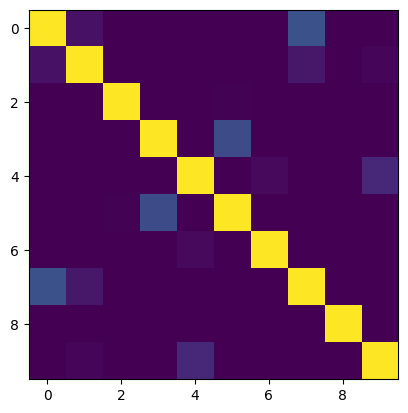

In [3]:
from linear_operator.operators import AddedDiagLinearOperator,AddedDiagLinearOperator,IdentityLinearOperator
from linear_operator.operators.identity_linear_operator import IdentityLinearOperator
from typing import Callable, List, Optional, Tuple, Union

def custom_preconditioner(operator: AddedDiagLinearOperator) -> Tuple[Optional[Callable], Optional[torch.Tensor]]:
    print("USING CUSTOM INJECTION")
    if settings.max_preconditioner_size.value() == 0 or operator.size(-1) < settings.min_preconditioning_size.value():
        return None, None, None

    # If the QR decomposition cache is not yet built, compute the pivoted Cholesky factorization.
    if operator._q_cache is None:
        max_iter = settings.max_preconditioner_size.value()
        operator._piv_chol_self = operator._linear_op.pivoted_cholesky(rank=max_iter)
        if torch.any(torch.isnan(operator._piv_chol_self)).item():
            warnings.warn(
                "NaNs encountered in custom preconditioner computation. Attempting to continue without preconditioning.",
                NumericalWarning,
            )
            return None, None, None
        operator._init_cache()

    def precondition_closure(tensor: torch.Tensor) -> torch.Tensor:
        qqt = operator._q_cache.matmul(operator._q_cache.mT.matmul(tensor))
        if operator._constant_diag:
            return (1 / operator._noise) * (tensor - qqt)
        else:
            return (tensor / operator._noise) - qqt

    return precondition_closure, operator._precond_lt, operator._precond_logdet_cache

base_kernel_gp = gpytorch.kernels.MaternKernel(
    ard_num_dims=train_x.shape[-1],
    lengthscale_prior=gpytorch.priors.GammaPrior(3.0, 6.0),
    nu=2.5
).to(device)
kernel = gpytorch.kernels.ScaleKernel(
    base_kernel_gp,
    outputscale_prior=gpytorch.priors.GammaPrior(2.0, 0.15)
).to(device)

n = 10
device = "cuda:0"
X = torch.randn(n).to(device)
scalar = 2.0  

K = kernel(X, X)

# Create the identity operator and ensure it is on the GPU
identity_operator = IdentityLinearOperator(diag_shape=X.shape[0], device=device, dtype=X.dtype)
identity_operator = identity_operator.to(device)
identity_operator.diag_values = identity_operator.diag_values.to(device)
print(identity_operator.diag_values.device)  # Should now be cuda:0

# Ensure both operators are on the same device
scaled_identity_operator=scalar*identity_operator
scaled_identity_operator = scaled_identity_operator.to(device)
scaled_identity_operator.diag_values = scaled_identity_operator.diag_values.to(device)

# Create the combined operator
test_op = AddedDiagLinearOperator(K, scaled_identity_operator, preconditioner_override=custom_preconditioner)

# Convert to dense and visualize
Khat_flat = test_op.to_dense()
plt.imshow(Khat_flat.detach().cpu())

Okay great, so we can overwrite the preconditioner function and still build the object. Now lets try to use it. We need to find the moment the kernel is converted into an added diag op so we can sneak in the preconditioner to the downstream invquadlodet call. in the Multivar class we have 
```python 
    @lazy_property
    def lazy_covariance_matrix(self) -> LinearOperator:
        if self.islazy:
            return self._covar
        else:
            return to_linear_operator(super().covariance_matrix)
```

The actual noising might be happening in `covar = covar.evaluate_kernel()` right before the invlogquad det, there might be a way to pass it into logquaddet?

The preconditioner override parameter can be set after the object is instatiated as a field variable function closure update. meaning we can jsut modify the custom multivariate normal class to do this taking in an extra arg. 

DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 
Iteration 1/50 - Loss: 1.2506744861602783
DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 
Iteration 2/50 - Loss: 1.2513402700424194
DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 
Iteration 3/50 - Loss: 1.2039155960083008
DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 
Iteration 4/50 - Loss: 1.1133590936660767
DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 
Iteration 5/50 - Loss: 1.1126703023910522
DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 
Iteration 6/50 - Loss: 1.0806525945663452
DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 
Iteration 7/50 - Loss: 1.0650852918624878
DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 
Iteration 8/50 - Loss: 1.0680804252624512
DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 
Iteration 9/50 - Loss: 1.032718539237976
DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 
Iteration 10/50 - Loss: 1.1211984157562256
DEBUG: USI

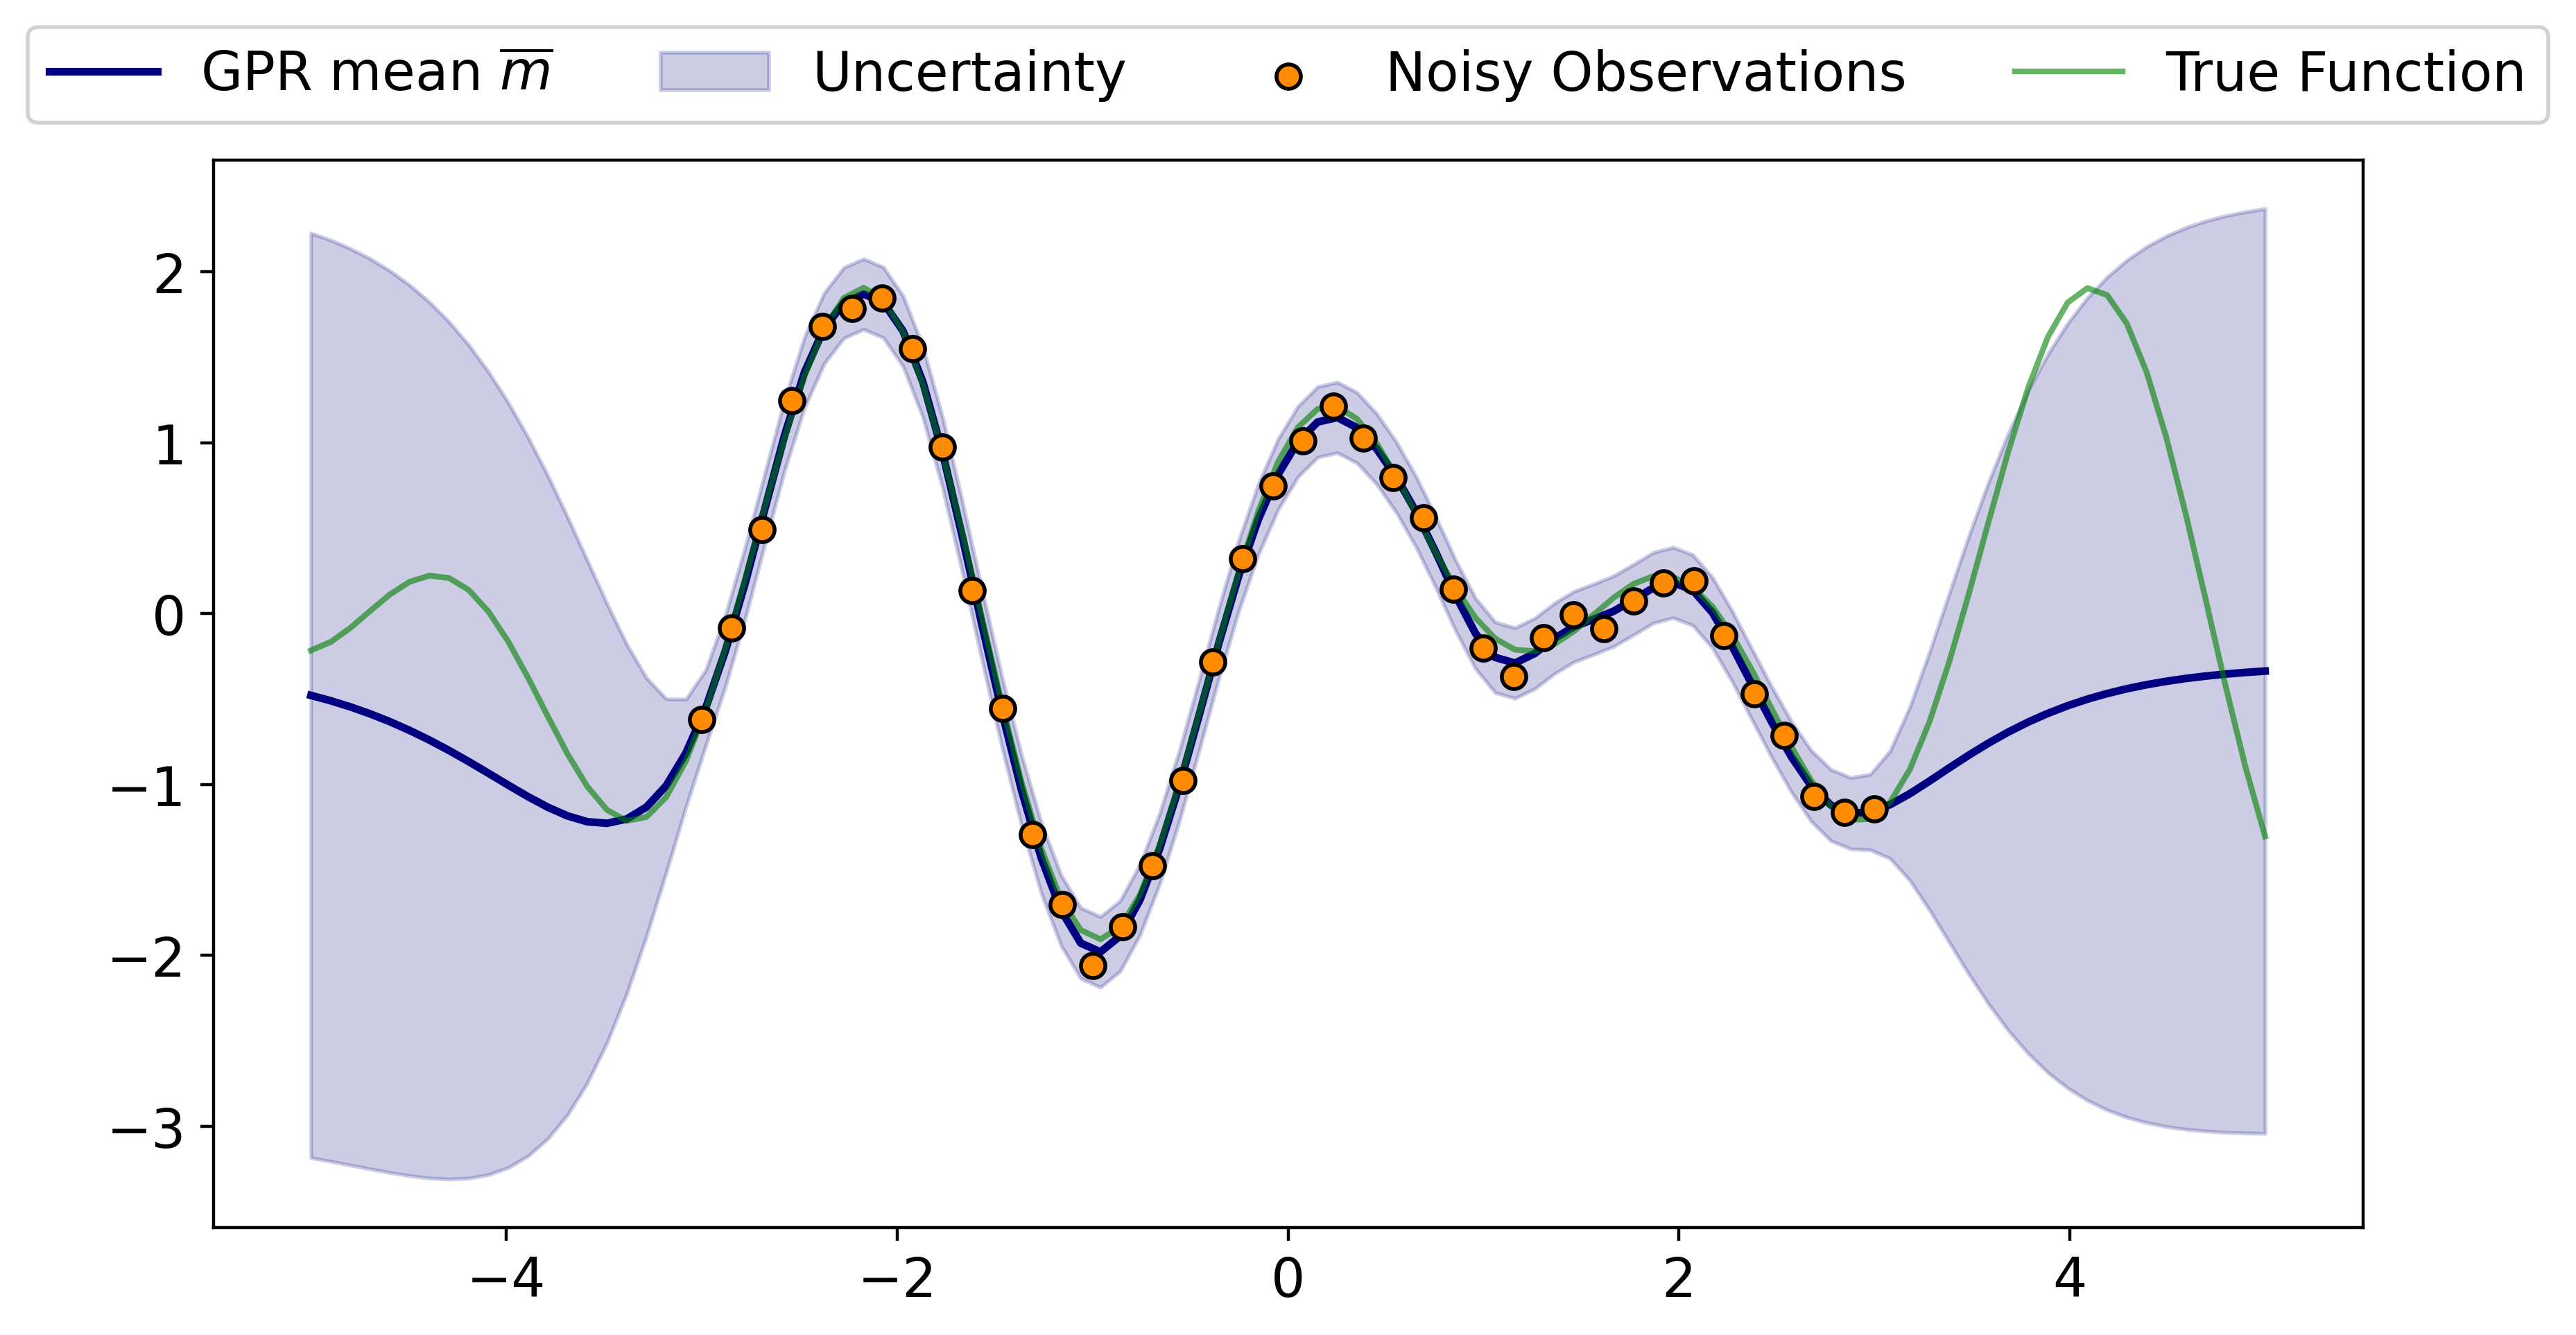

In [5]:
#!/usr/bin/env python3
import math
import warnings
from typing import Callable, Optional, Tuple

import torch
import gpytorch
from torch import Tensor

from linear_operator.operators.added_diag_linear_operator import AddedDiagLinearOperator
from linear_operator import settings
from linear_operator.utils.warnings import NumericalWarning


class CustomPrecondtionedGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel,preconditioner_closure=None):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.preconditioner_closure = None
        self.covar_module = preconditioner_closure

    def forward(self, x,dump_args=False):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        if dump_args:
            return CustomMultivariateNormal(mean_x, covar_x,self.preconditioner_closure),mean_x,covar_x #<-- subject,
        return CustomMultivariateNormal(mean_x, covar_x,self.preconditioner_closure) #<-- subject

def custom_preconditioner(operator: AddedDiagLinearOperator) -> Tuple[Optional[Callable], Optional[torch.Tensor], Optional[torch.Tensor]]:
    print("DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 ")
    if settings.max_preconditioner_size.value() == 0 or operator.size(-1) < settings.min_preconditioning_size.value():
        return None, None, None
    if operator._q_cache is None:
        max_iter = settings.max_preconditioner_size.value()
        operator._piv_chol_self = operator._linear_op.pivoted_cholesky(rank=max_iter)
        if torch.any(torch.isnan(operator._piv_chol_self)).item():
            warnings.warn("NaNs encountered in custom preconditioner computation. Attempting to continue without preconditioning.", NumericalWarning)
            return None, None, None
        operator._init_cache()
    def precondition_closure(tensor: torch.Tensor) -> torch.Tensor:
        qqt = operator._q_cache.matmul(operator._q_cache.mT.matmul(tensor))
        if operator._constant_diag:
            return (1 / operator._noise) * (tensor - qqt)
        else:
            return (tensor / operator._noise) - qqt
    return precondition_closure, operator._precond_lt, operator._precond_logdet_cache

from linear_operator.operators.dense_linear_operator import DenseLinearOperator
from linear_operator.operators.dense_linear_operator import DenseLinearOperator

class CustomDenseLinearOperator(DenseLinearOperator):
    def __init__(self, tensor: torch.Tensor, preconditioner_closure=None):
        super().__init__(tensor)
        self._preconditioner_closure = preconditioner_closure

    def _preconditioner(self):
        if self._preconditioner_closure is not None:
            return self._preconditioner_closure(self)
        return super()._preconditioner()

class CustomMultivariateNormal(gpytorch.distributions.MultivariateNormal):
    def __init__(self, mean: Tensor, covariance_matrix, custom_preconditioner=None):
        if hasattr(covariance_matrix, "evaluate_kernel"):
            evaluated_cov = covariance_matrix.evaluate_kernel()
        else:
            evaluated_cov = covariance_matrix
        from linear_operator.operators.dense_linear_operator import DenseLinearOperator
        if isinstance(evaluated_cov, torch.Tensor):
            evaluated_cov = DenseLinearOperator(evaluated_cov)
        if isinstance(evaluated_cov, DenseLinearOperator) and not isinstance(evaluated_cov, CustomDenseLinearOperator):
            evaluated_cov = CustomDenseLinearOperator(evaluated_cov.tensor, preconditioner_closure=custom_preconditioner)
        if not hasattr(evaluated_cov, "_preconditioner_closure"):
            print("DEBUG: Evaluated covariance is of type", type(evaluated_cov), "which does not support our custom preconditioner storage.")
        super().__init__(mean, evaluated_cov)
        self.custom_preconditioner = custom_preconditioner

    def log_prob(self, value: Tensor) -> Tensor:
        if gpytorch.settings.fast_computations.log_prob.off():
            return super().log_prob(value)
        if self._validate_args:
            self._validate_sample(value)
        mean, covar = self.loc, self.lazy_covariance_matrix
        diff = value - mean
        if diff.shape[:-1] != covar.batch_shape:
            if len(diff.shape[:-1]) < len(covar.batch_shape):
                diff = diff.expand(covar.shape[:-1])
            else:
                padded_batch_shape = (*(1 for _ in range(diff.dim() + 1 - covar.dim())), *covar.batch_shape)
                diff = diff.expand(padded_batch_shape)
                covar = covar.repeat(*(diff_size // covar_size for diff_size, covar_size in zip(diff.shape[:-1], padded_batch_shape)), 1, 1)
        #print("before eval", type(covar))
        evaluated_cov = covar.evaluate_kernel()
        evaluated_cov = CustomDenseLinearOperator(evaluated_cov.tensor, preconditioner_closure=self.custom_preconditioner)
        #print("after eval", type(evaluated_cov))
        #print()
        inv_quad, logdet = evaluated_cov.inv_quad_logdet(inv_quad_rhs=diff.unsqueeze(-1), logdet=True)
        res = -0.5 * (inv_quad + logdet + diff.size(-1) * math.log(2 * math.pi))
        return res

class CustomExactMarginalLogLikelihood(gpytorch.mlls.ExactMarginalLogLikelihood):
    def __init__(self, likelihood, model, custom_preconditioner=None):
        super().__init__(likelihood, model)
        self.custom_preconditioner = custom_preconditioner

    def forward(self, function_dist, target, *params):
        transformed_dist = self.likelihood(function_dist, *params)
        if not isinstance(transformed_dist, CustomMultivariateNormal):
            #print("DEBUG: Wrapping likelihood-transformed function_dist in CustomMultivariateNormal.")
            transformed_dist = CustomMultivariateNormal(transformed_dist.mean, transformed_dist.covariance_matrix, custom_preconditioner=self.custom_preconditioner)
        res = transformed_dist.log_prob(target)
        res = self._add_other_terms(res, params)
        num_data = transformed_dist.event_shape.numel()
        return res.div_(num_data)

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x: Tensor, train_y: Tensor, likelihood: gpytorch.likelihoods.GaussianLikelihood, kernel: gpytorch.kernels.Kernel):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel
    def dump_args(self,x):
        return self.mean_module(x), self.covar_module(x)
    def forward(self, x: Tensor,dump_args=False):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def true_function(x: Tensor) -> Tensor:
    return torch.sin(2 * x) + torch.cos(3 * x)

def generate_data(true_function, train_range=(-3, 3), test_range=(-3, 3), n_train=40, n_test=100, noise_std=0.1, device="cuda:0", dtype=torch.float32):
    X_train = torch.linspace(train_range[0], train_range[1], n_train, dtype=dtype, device=device).unsqueeze(-1)
    y_train = true_function(X_train) + noise_std * torch.randn_like(X_train)
    X_test = torch.linspace(test_range[0], test_range[1], n_test, dtype=dtype, device=device).unsqueeze(-1)
    y_test = true_function(X_test)
    return X_train, y_train.squeeze(), X_test, y_test.squeeze()

global_dtype = torch.float32
device = torch.device("cuda:0")
train_x, train_y, test_x, test_y = generate_data(true_function, test_range=(-5, 5), dtype=global_dtype, device=device)

likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
base_kernel = MaternKernel(
    ard_num_dims=train_x.shape[-1],
    lengthscale_prior=GammaPrior(3.0, 6.0),
    nu=2.5
)
kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)
model = ExactGPModel(train_x, train_y, likelihood, kernel).to(device)

model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = CustomExactMarginalLogLikelihood(likelihood, model, custom_preconditioner=custom_preconditioner)

with gpytorch.settings.max_cholesky_size(1):
    training_iterations = 50
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        print(f"Iteration {i + 1}/{training_iterations} - Loss: {loss.item()}")

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    pred_mean = observed_pred.mean
    pred_variance = observed_pred.variance
    pred_std = torch.sqrt(pred_variance)

plot_gp_simple(train_x, train_y, test_x, pred_mean, pred_std, test_y)

In [6]:
def plot_gp_sample_gpy(
    train_x, train_y, test_x_extended, test_y,
    true_function, GP_mean, std, num_samples=45
):
    # GP_mean, GP_covariance = gpr.predict(test_x_extended)
    

    
    # Draw samples from the multivariate Gaussian.
    samples = np.random.multivariate_normal(GP_mean, GP_covariance, size=num_samples)
    
    plt.figure(figsize=(10, 5), dpi=400)
    colors = cm.Blues(np.linspace(0.3, 0.8, num_samples))
    x_vals = np.array(test_x_extended).ravel()
    for i in range(num_samples):
        plt.plot(x_vals, samples[i], color=colors[i], alpha=0.3, lw=1)
    
    uncertainty_handle = plt.fill_between(
        x_vals, GP_mean -1.96* std, GP_mean +1.96* std,
        color='royalblue', alpha=0.4, label='Uncertainty',
        linestyle="-", zorder=3,
    )
    
    mean_handle, = plt.plot(
        x_vals, GP_mean,
        color='darkblue', lw=2.5, label=r'GPR mean $\overline{m}$', zorder=4,
    )
    
    noisy_handle = plt.scatter(
        np.array(train_x).ravel(), np.array(train_y).ravel(),
        s=45, color='darkorange', edgecolors='black',
        label='Noisy Observations', zorder=5, linewidth=1
    )
    
    # Determine true function values over test_x_extended.
    if test_y.shape == test_x_extended.shape:
        true_y_extended = test_y
    else:
        true_y_extended = true_function(test_x_extended)
    
    true_handle, = plt.plot(
        x_vals, np.array(true_y_extended).ravel(),
        color='green', alpha=1, lw=2, label="True Function", zorder=3
    )
    
    # Draw dashed vertical lines indicating the training interval boundaries.
    plt.axvline(x=-3, color='black', linestyle='dashed', alpha=0.5, lw=1.8)
    plt.axvline(x=3, color='black', linestyle='dashed', alpha=0.5, lw=1.8)
    
    # Shade regions outside the training interval.
    plt.axvspan(-5, -3, color='gray', alpha=0.1)
    plt.axvspan(3, 5, color='gray', alpha=0.1)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    handles = [mean_handle, uncertainty_handle, noisy_handle, true_handle]
    plt.legend(handles=handles, fontsize=13, loc='upper center', bbox_to_anchor=(0.5, 1.15),
               ncol=4, fancybox=True, shadow=True, framealpha=1)
    plt.show()

C:\Users\fredw\AppData\Local\Temp\ipykernel_22616\4037580639.py:13: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(GP_mean, GP_covariance, size=num_samples)
C:\Users\fredw\AppData\Local\Temp\ipykernel_22616\4037580639.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x_vals = np.array(test_x_extended).ravel()
C:\Users\fredw\AppData\Local\Temp\ipykernel_22616\4037580639.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.array(train_x).ravel(), np.array(train_y).ravel(),
C:\Users\fredw\AppData\Local\Temp\ipykernel_22616\4037580639.py:47: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype'

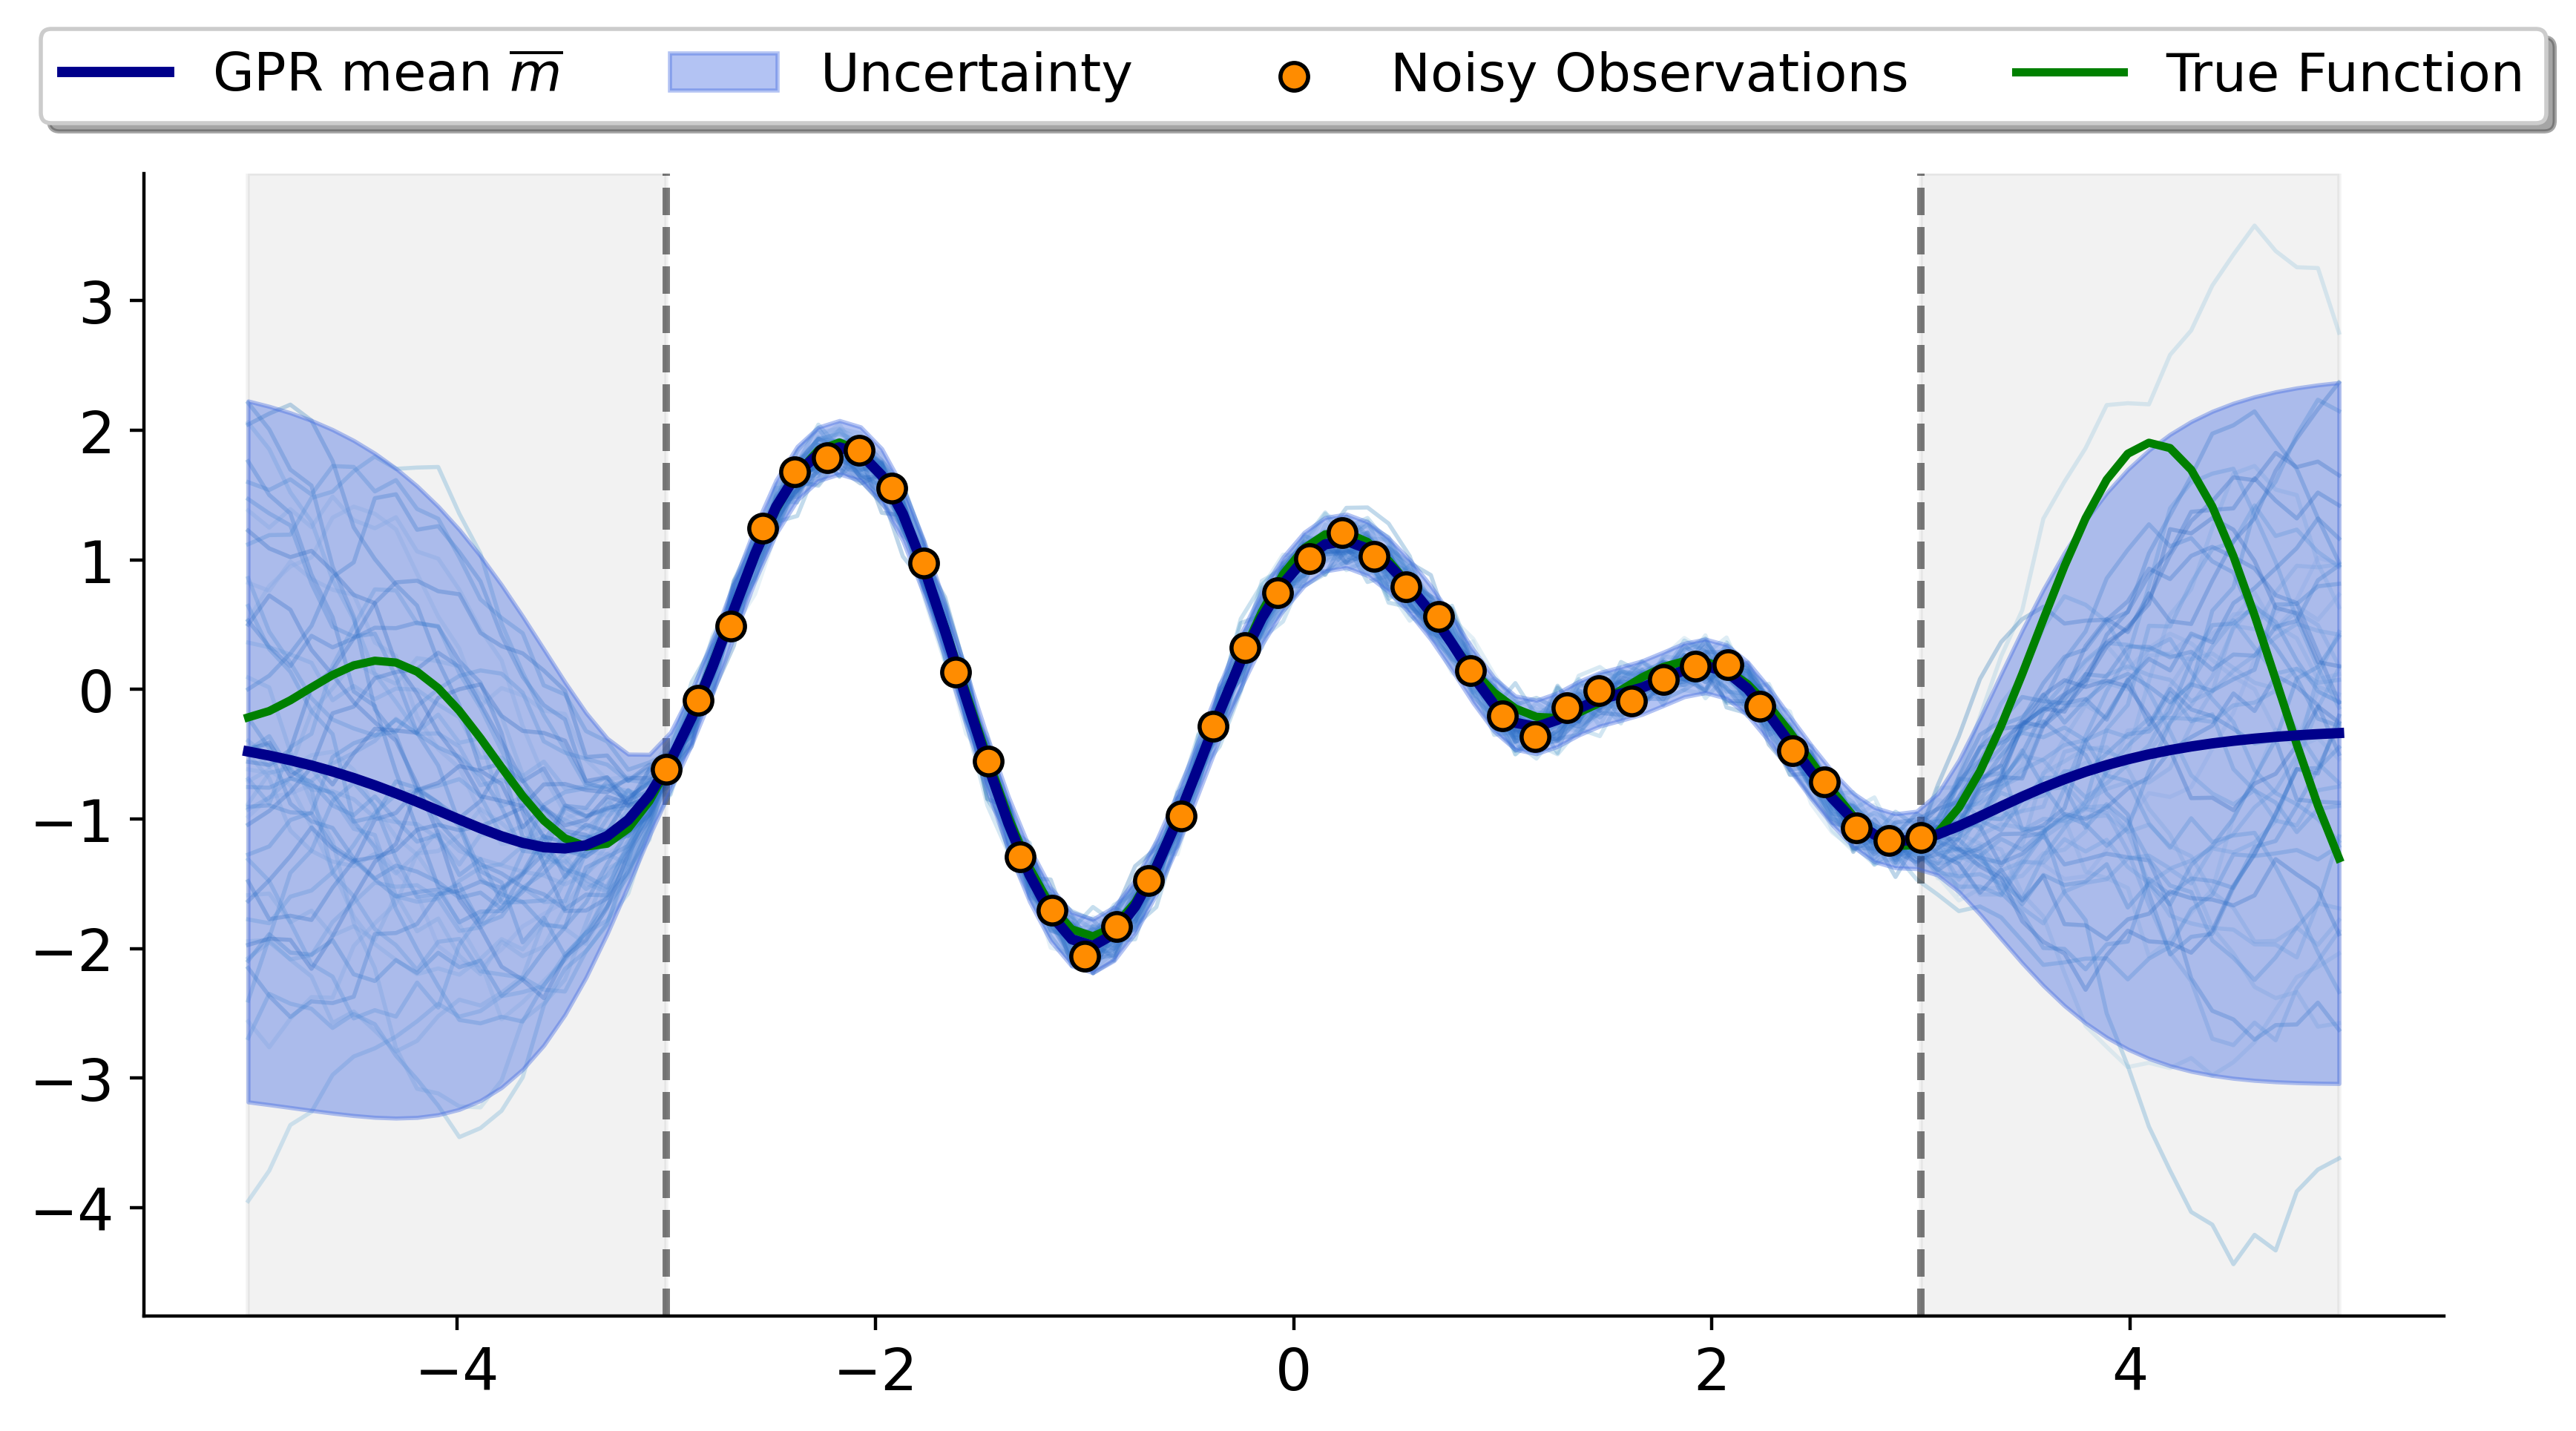

In [7]:
#!/usr/bin/env python3
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_gp_sample_gpy(
    train_x, train_y, test_x_extended, test_y,
    true_function, GP_mean, GP_covariance, num_samples=45
):
    # Draw samples from the multivariate Gaussian using the full covariance.
    samples = np.random.multivariate_normal(GP_mean, GP_covariance, size=num_samples)
    
    plt.figure(figsize=(10, 5), dpi=400)
    colors = cm.Blues(np.linspace(0.3, 0.8, num_samples))
    x_vals = np.array(test_x_extended).ravel()
    for i in range(num_samples):
        plt.plot(x_vals, samples[i], color=colors[i], alpha=0.3, lw=1)
    
    # Here we compute uncertainty bounds using the diagonal of the covariance matrix.
    std = np.sqrt(np.diag(GP_covariance))
    uncertainty_handle = plt.fill_between(
        x_vals, GP_mean - 1.96 * std, GP_mean + 1.96 * std,
        color='royalblue', alpha=0.4, label='Uncertainty',
        linestyle="-", zorder=3,
    )
    
    mean_handle, = plt.plot(
        x_vals, GP_mean,
        color='darkblue', lw=2.5, label=r'GPR mean $\overline{m}$', zorder=4,
    )
    
    noisy_handle = plt.scatter(
        np.array(train_x).ravel(), np.array(train_y).ravel(),
        s=45, color='darkorange', edgecolors='black',
        label='Noisy Observations', zorder=5, linewidth=1
    )
    
    # Determine true function values over test_x_extended.
    if test_y.shape == test_x_extended.shape:
        true_y_extended = test_y
    else:
        true_y_extended = true_function(test_x_extended)
    
    true_handle, = plt.plot(
        x_vals, np.array(true_y_extended).ravel(),
        color='green', alpha=1, lw=2, label="True Function", zorder=3
    )
    
    # Draw dashed vertical lines indicating the training interval boundaries.
    plt.axvline(x=-3, color='black', linestyle='dashed', alpha=0.5, lw=1.8)
    plt.axvline(x=3, color='black', linestyle='dashed', alpha=0.5, lw=1.8)
    
    # Shade regions outside the training interval.
    plt.axvspan(-5, -3, color='gray', alpha=0.1)
    plt.axvspan(3, 5, color='gray', alpha=0.1)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    handles = [mean_handle, uncertainty_handle, noisy_handle, true_handle]
    plt.legend(handles=handles, fontsize=13, loc='upper center', bbox_to_anchor=(0.5, 1.15),
               ncol=4, fancybox=True, shadow=True, framealpha=1)
    plt.show()

# Suppose test_x_extended is defined as follows:
test_x_extended = torch.linspace(-5, 5, 100).to(dtype=train_x.dtype, device="cpu")

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Note: use test_x_extended for predictions if you want the full range.
    observed_pred = likelihood(model(test_x_extended.to("cuda:0")))
    GP_mean = observed_pred.mean.detach().cpu().numpy()
    GP_covariance = observed_pred.covariance_matrix.detach().cpu().numpy()
    # pred_std is no longer used for sampling but can be used for uncertainty plots
    pred_std = np.sqrt(np.diag(GP_covariance))

plot_gp_sample_gpy(
    train_x.cpu(), train_y.cpu(), test_x_extended.cpu(), test_y.cpu(),
    true_function, GP_mean, GP_covariance,
    num_samples=50
)

Running baseline experiment...
Iteration 1/50 - Total Loss: 1.2477
Iteration 2/50 - Total Loss: 1.2089
Iteration 3/50 - Total Loss: 1.1739
Iteration 4/50 - Total Loss: 1.1424
Iteration 5/50 - Total Loss: 1.1146
Iteration 6/50 - Total Loss: 1.0895
Iteration 7/50 - Total Loss: 1.0651
Iteration 8/50 - Total Loss: 1.0396
Iteration 9/50 - Total Loss: 1.0124
Iteration 10/50 - Total Loss: 0.9835
Iteration 11/50 - Total Loss: 0.9533
Iteration 12/50 - Total Loss: 0.9222
Iteration 13/50 - Total Loss: 0.8908
Iteration 14/50 - Total Loss: 0.8596
Iteration 15/50 - Total Loss: 0.8290
Iteration 16/50 - Total Loss: 0.7993
Iteration 17/50 - Total Loss: 0.7702
Iteration 18/50 - Total Loss: 0.7414
Iteration 19/50 - Total Loss: 0.7123
Iteration 20/50 - Total Loss: 0.6827
Iteration 21/50 - Total Loss: 0.6526
Iteration 22/50 - Total Loss: 0.6224
Iteration 23/50 - Total Loss: 0.5926
Iteration 24/50 - Total Loss: 0.5635
Iteration 25/50 - Total Loss: 0.5353
Iteration 26/50 - Total Loss: 0.5078
Iteration 27/50 

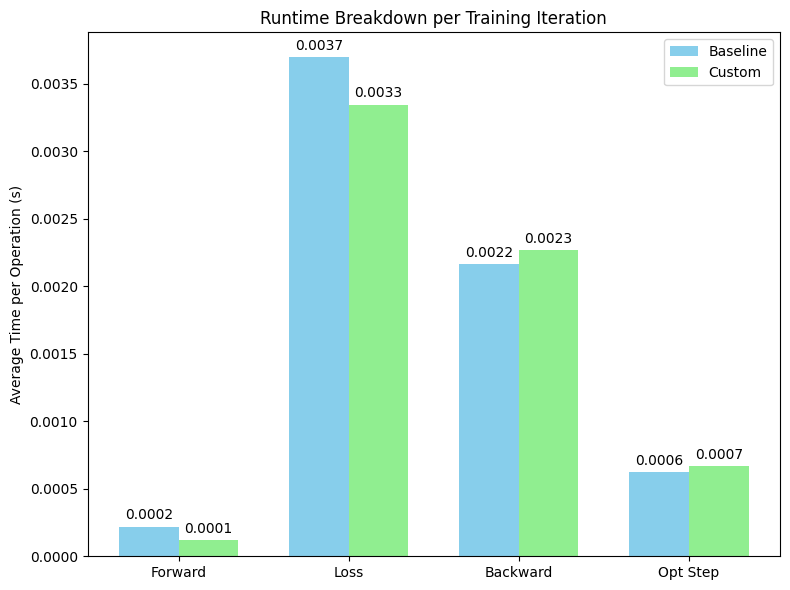

In [9]:
#!/usr/bin/env python3
import math
import time
import warnings
from typing import Callable, Optional, Tuple

import torch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
from torch import Tensor

# For this example, we assume that our custom likelihood is defined here.
# The baseline model uses the standard gpytorch.mlls.ExactMarginalLogLikelihood.

from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import MaternKernel, ScaleKernel

# Define a true function for data generation.
def true_function(x: Tensor) -> Tensor:
    return torch.sin(2 * x) + torch.cos(3 * x)

# Data generation function.
def generate_data(true_function, train_range=(-3, 3), test_range=(-3, 3),
                  n_train=40, n_test=100, noise_std=0.1,
                  device="cuda:0", dtype=torch.float32):
    X_train = torch.linspace(train_range[0], train_range[1], n_train, dtype=dtype, device=device).unsqueeze(-1)
    y_train = true_function(X_train) + noise_std * torch.randn_like(X_train)
    X_test = torch.linspace(test_range[0], test_range[1], n_test, dtype=dtype, device=device).unsqueeze(-1)
    y_test = true_function(X_test)
    return X_train, y_train.squeeze(), X_test, y_test.squeeze()

# Baseline Exact GP model.
class ExactGPModel(ExactGP):
    def __init__(self, train_x: Tensor, train_y: Tensor,
                 likelihood: GaussianLikelihood, kernel: gpytorch.kernels.Kernel):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x: Tensor, dump_args=False):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Customized marginal log likelihood.
class CustomExactMarginalLogLikelihood(gpytorch.mlls.ExactMarginalLogLikelihood):
    def __init__(self, likelihood, model, custom_preconditioner=None):
        super().__init__(likelihood, model)
        self.custom_preconditioner = custom_preconditioner

    def forward(self, function_dist, target, *params):
        transformed_dist = self.likelihood(function_dist, *params)
        # In this example the loss is computed as:
        # \(\mathcal{L} = -\log p(y|f(x))\)
        res = transformed_dist.log_prob(target)
        res = self._add_other_terms(res, params)
        num_data = transformed_dist.event_shape.numel()
        return res.div_(num_data)

def custom_preconditioner(operator: AddedDiagLinearOperator) -> Tuple[Optional[Callable], Optional[torch.Tensor], Optional[torch.Tensor]]:
    print("DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 ")
    if settings.max_preconditioner_size.value() == 0 or operator.size(-1) < settings.min_preconditioning_size.value():
        return None, None, None
    if operator._q_cache is None:
        max_iter = settings.max_preconditioner_size.value()
        operator._piv_chol_self = operator._linear_op.pivoted_cholesky(rank=max_iter)
        if torch.any(torch.isnan(operator._piv_chol_self)).item():
            warnings.warn("NaNs encountered in custom preconditioner computation. Attempting to continue without preconditioning.", NumericalWarning)
            return None, None, None
        operator._init_cache()
    def precondition_closure(tensor: torch.Tensor) -> torch.Tensor:
        qqt = operator._q_cache.matmul(operator._q_cache.mT.matmul(tensor))
        if operator._constant_diag:
            return (1 / operator._noise) * (tensor - qqt)
        else:
            return (tensor / operator._noise) - qqt
    return precondition_closure, operator._precond_lt, operator._precond_logdet_cache

# Global parameters and data.
global_dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# train_x, train_y, test_x, test_y = generate_data(true_function, test_range=(-5, 5),
#                                                   dtype=global_dtype, device=device)

# Kernel definitions.
base_kernel_gp = MaternKernel(
    ard_num_dims=train_x.shape[-1],
    lengthscale_prior=gpytorch.priors.GammaPrior(3.0, 6.0),
    nu=2.5
).to(device)
kernel_gp = ScaleKernel(
    base_kernel_gp,
    outputscale_prior=gpytorch.priors.GammaPrior(2.0, 0.15)
).to(device)

# Function to run a timing experiment.
def run_experiment(use_custom: bool, training_iterations: int = 50):
    # Create a fresh likelihood and model for each experiment.
    likelihood_local = GaussianLikelihood().to(device)
    model_local = ExactGPModel(train_x, train_y, likelihood_local, kernel_gp).to(device)
    model_local.train()
    likelihood_local.train()
    optimizer = torch.optim.Adam(model_local.parameters(), lr=0.1)
    if use_custom:
        mll = CustomExactMarginalLogLikelihood(likelihood_local, model_local,
                                                 custom_preconditioner=custom_preconditioner)
    else:
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_local, model_local)

    # Initialize lists for timing the operations.
    forward_times = []
    loss_times = []
    backward_times = []
    opt_step_times = []

    for i in range(training_iterations):
        optimizer.zero_grad()
        if device.type == "cuda":
            torch.cuda.synchronize()
        t0 = time.time()
        
        # Forward pass: computing the model output.
        output = model_local(train_x)
        if device.type == "cuda":
            torch.cuda.synchronize()
        t1 = time.time()
        
        # Loss evaluation: computing the marginal log likelihood.
        loss = -mll(output, train_y)
        if device.type == "cuda":
            torch.cuda.synchronize()
        t2 = time.time()
        
        # Backward pass: gradient computation.
        loss.backward()
        if device.type == "cuda":
            torch.cuda.synchronize()
        t3 = time.time()
        
        # Optimizer step: updating parameters.
        optimizer.step()
        if device.type == "cuda":
            torch.cuda.synchronize()
        t4 = time.time()
        
        # Record times.
        forward_times.append(t1 - t0)
        loss_times.append(t2 - t1)
        backward_times.append(t3 - t2)
        opt_step_times.append(t4 - t3)
        
        print(f"Iteration {i+1}/{training_iterations} - Total Loss: {loss.item():.4f}")

    return {
        'forward': np.mean(forward_times),
        'loss': np.mean(loss_times),
        'backward': np.mean(backward_times),
        'opt_step': np.mean(opt_step_times)
    }

# Run experiments for both methods.
training_iterations = 50
print("Running baseline experiment...")
baseline_results = run_experiment(use_custom=True, training_iterations=training_iterations)
print("Running custom experiment...")
custom_results = run_experiment(use_custom=False, training_iterations=training_iterations)

# Prepare data for grouped bar plot.
categories = ['Forward', 'Loss', 'Backward', 'Opt Step']
baseline_values = [baseline_results['forward'], baseline_results['loss'],
                   baseline_results['backward'], baseline_results['opt_step']]
custom_values = [custom_results['forward'], custom_results['loss'],
                 custom_results['backward'], custom_results['opt_step']]

x = np.arange(len(categories))  # the label locations
width = 0.35  # width of each bar

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, baseline_values, width, label='Baseline', color='skyblue')
rects2 = ax.bar(x + width/2, custom_values, width, label='Custom', color='lightgreen')

ax.set_ylabel("Average Time per Operation (s)")
ax.set_title("Runtime Breakdown per Training Iteration")
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Attach a text label above each bar displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f"{height:.4f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

Okay next step is to asses the vulnerability of the logdet invocation. 

GPyTorch Training: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


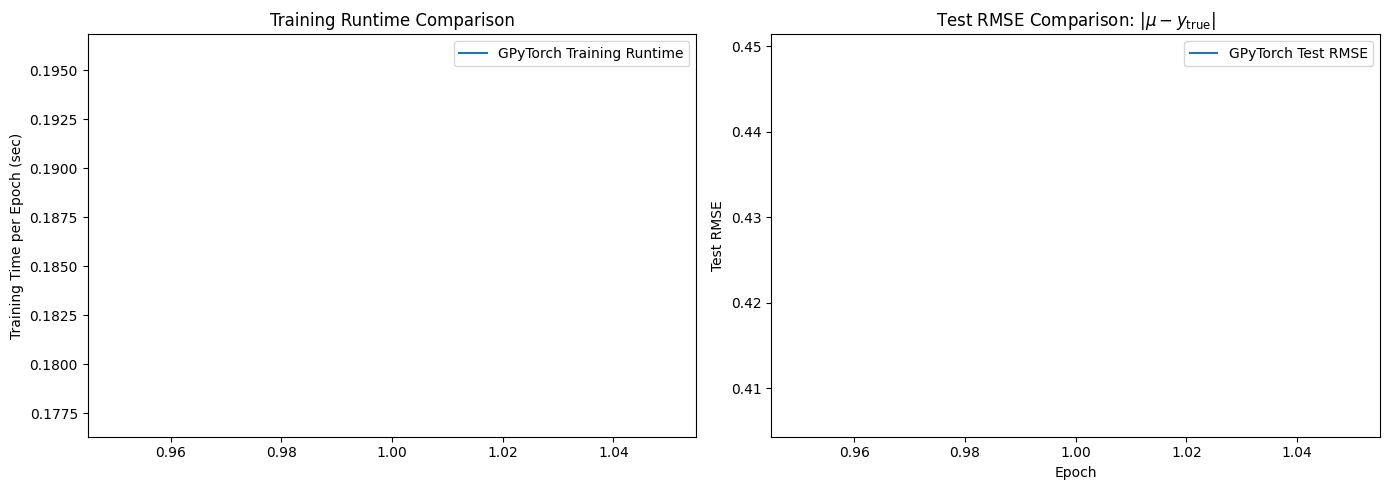

In [8]:

def train_gpytorch_model(model, likelihood, mll, optimizer, train_x, train_y, test_x, test_y, training_iterations=100):
    runtime_log, rmse_log = [], []
    #Per When are Iterative Gaussian Processes Reliably Accurate? Maddox et al 2021
    with gpytorch.settings.eval_cg_tolerance(1e-2), \
        gpytorch.settings.max_cg_iterations(100), \
        gpytorch.settings.cg_tolerance(1e-3),\
        gpytorch.settings.max_preconditioner_size(50), \
        gpytorch.settings.max_root_decomposition_size(5000), \
        gpytorch.settings.deterministic_probes(state=False), \
        gpytorch.settings.fast_computations(covar_root_decomposition=True, log_prob=True, solves=True), \
        gpytorch.settings.num_trace_samples(16), \
        gpytorch.settings.skip_posterior_variances(state=False), \
        gpytorch.settings.fast_pred_var():
        for epoch in tqdm(range(training_iterations), desc="GPyTorch Training"):
            model.train()
            likelihood.train()

            start_time = time.time()
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            epoch_time = time.time() - start_time
            optimizer.step()

            runtime_log.append(epoch_time)

            with torch.no_grad():
                model.eval()
                likelihood.eval()
                with torch.no_grad(), gpytorch.settings.fast_pred_var():
                    observed_pred = likelihood(model(test_x))
                mean_pred = observed_pred.mean
                rmse = torch.mean(torch.abs(mean_pred - test_y)).item()
            rmse_log.append(rmse)

            if (epoch + 1) % 20 == 0:
                print(f"[GPyTorch] Epoch {epoch+1}/{training_iterations}, Time: {epoch_time:.4f} sec, RMSE: {rmse:.4f}")
    
    return runtime_log, rmse_log

training_iterations = 1
lr =.05
# Assume train_x, train_y, test_x, test_y are defined elsewhere
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_dtype = torch.float32

#============== Iterative ==============
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise=0.4).to(device)
base_kernel_gp = gpytorch.kernels.MaternKernel(
    ard_num_dims=train_x.shape[-1],
    lengthscale_prior=gpytorch.priors.GammaPrior(3.0, 6.0),
    nu=2.5
).to(device)
kernel_gp = gpytorch.kernels.ScaleKernel(
    base_kernel_gp,
    outputscale_prior=gpytorch.priors.GammaPrior(2.0, 0.15)
).to(device)

gp_model = ExactGPModel(train_x, train_y, likelihood, kernel_gp).to(device)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)
optimizer = torch.optim.Adam(gp_model.parameters(), lr=lr)

gp_runtime, gp_rmse = train_gpytorch_model(
    gp_model, likelihood, mll, optimizer, train_x, train_y, test_x, test_y,
    training_iterations=training_iterations
)

#============== Plots ==============
epochs = np.arange(1, training_iterations + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(epochs, gp_runtime, label="GPyTorch Training Runtime")
axes[0].set_ylabel("Training Time per Epoch (sec)")
axes[0].set_title("Training Runtime Comparison")
axes[0].legend()

axes[1].plot(epochs, gp_rmse, label="GPyTorch Test RMSE")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Test RMSE")
axes[1].set_title(r"Test RMSE Comparison: $|\mu - y_{\text{true}}|$")
axes[1].legend()

plt.tight_layout()
plt.show()